## CMSC643 : Machine Learning 

## Mahdi Navari

## Project 1:

### Similar document searching via MinHash and Locality Sensitive Hashing
In this first project we will implement the system described in the lecture notes for similar document searching. This project is inspired by http://mccormickml.com/2015/06/12/minhash-tutorial-with-python-code/ (Note: you can look at code there for inspiration but implement your own).
The Task
We will use documents from this repository http://www.inf.ed.ac.uk/teaching/courses/tts/assessed/assessment3.html. This is a dataset of documents for which we want to find possible plagiarism. It consists of 10,000 documents for which some pairs are tagged as instances of plagiarism. The goal of this exercise is to see how effectively and efficiently a minhash and LSH system can identify these instances.
Note that smaller subsets of data suitable for testing are available here: https://github.com/chrisjmccormick/MinHash/tree/master/data\

### Obtaining data
 You can use the following python code to download data for the project



In [1]:

import os
from six.moves import urllib


DOWNLOAD_ROOT = "https://raw.githubusercontent.com/chrisjmccormick/MinHash/master/data"
PLAGIARISM_PATH = "datasets/plagiarism"
DATA_SIZES = [100,1000,2500,10000]

def fetch_data(download_root=DOWNLOAD_ROOT, 
               plagiarism_path=PLAGIARISM_PATH, 
               data_sizes=DATA_SIZES,
               maxsize=1000):
  if not os.path.isdir(plagiarism_path):
      os.makedirs(plagiarism_path)
  for size in data_sizes:
      if size <= maxsize:
          train_file = "articles_" + str(size) + ".train" 
          train_path = plagiarism_path + '/' + train_file
          if not os.path.exists(train_path):
              train_url = download_root + '/' + train_file
              urllib.request.urlretrieve(train_url, train_path)
          
          truth_file = "articles_" + str(size) + ".truth"
          truth_path = plagiarism_path + '/' + truth_file
          if not os.path.exists(truth_path):
              truth_url = download_root + "/" + truth_file
              urllib.request.urlretrieve(truth_url, truth_path)
                
                
fetch_data(maxsize=1000)


## Part I: Preliminaries
### Part IA: Dataset parsing
Write a function parse_datathat given the path to a filename, reads in the article data and returns an array of tuples. With

One tuple per article (there is one article per line)

For each article tuples will contain (id, string) where id is the article id and string is the article text as described next

Process the article text to
- remove all punctuation
- change all letters to lowercase
- remove all whitespace so that all words are concatenated


In [2]:
import string 

def parse_data(filename):
    
  # read lines from filename
    f = open(filename, 'r')
    lines = f.readlines()
    
    # construct tuple of id and text
    doc_tuples = []
    for line in lines: 
        
        space_index = line.find(' ')
        docid = line[:space_index]
        text = line[space_index+1:]      
        
        # process string as described above  
        translator = str.maketrans('', '', string.punctuation)
        text = text.translate(translator)       
        text = text.lower().replace(" ", "")
        
       # return tuple with id and processed string       
        doc_tuples.append ((docid,text)) 
    return doc_tuples

In [4]:
#file_name= PLAGIARISM_PATH + '/articles_100.train'
#parse_data(file_name)

### Part IB: Document shingles
Write a function shingle_document that given a processed article string and a parameter k shards the document as follows:
- each substring of length $k$ in document is hashed to a 32-bit integer (see crc32 fucntion in https://docs.python.org/3/library/binascii.html)
- returns a list of the unique 32-bit integers obtained in previous step (look at python sets for this)

In [3]:
from binascii import crc32
def shingle_document(text,k):
    itemset = set()
    for i in range (len(text)-k+1):
        item = text[i:(i+k)]
        item_hash = crc32(item.encode()) & 0xffffffff
        itemset.add(item_hash)
    return itemset

### 1C Jaccard Similarity
Write a function jaccard that given two sharded documents, computes their Jaccard distance

In [4]:
def jaccard(a, b):
  # compute union size
   union_size = len (a.union(b))
  # compute intersection size
   intersection_size = len (a.intersection(b))
  # return ratio of union and intersection
   return intersection_size / union_size  

### Part ID: Put these together
Write a function that uses the above to do the following:
- Parse a file with data
- Return a list of tuples each tuple contains: (id1, id2, s), where id1 and id2 are document ids and s is the computed Jaccard similarity

In [5]:
def documents_JS (filename , k):
    similarity_tuples = []
    parsed_data = parse_data(filename)
    for i in range(len(parsed_data)):
        for j in range(i+1, len(parsed_data)):
            s1 = shingle_document(parsed_data[i][1],k)
            s2 = shingle_document(parsed_data[j][1],k)
            JSim = jaccard(s1, s2)
            id1 = parsed_data[i][0]
            id2 = parsed_data[j][0]
            similarity_tuples.append ((id1,id2, JSim))          
    return similarity_tuples


In [6]:
# test
#documents_JS("datasets/plagiarism/articles_100.train",5)

### Part IE: Experiment 0

Use your function to carry out the following experiment:

What is the effect of sharding length k on the Jaccard similarity of plagiarism instances versus instances that are not plagiarized. Carry out this experiment using the 1000 document dataset. 

In this experiment, the size of k was changed from 2 to 30

In [7]:
# Generate two lists  
# 1) list of plagiarized documents 
# 2) list of random non-palgiarized documents 

import random
import numpy as np
def list_of_plagiarized_nonpalgiarized_doc (fname_train, fname_truth):
    import random
    f=open(fname_truth,'r') 
    plagiarized_list=[]
    non_plagiarized_list=[]
    lines=f.readlines()

    list_truth=[]
    for line in lines:
        # extract documents ids  
        doc_id1 = line.split(' ')[0]
        doc_id2 = line.split(' ')[1].strip()
        list_truth.append(doc_id1)
        list_truth.append(doc_id2)    
        
        truth_tuples=(doc_id1,doc_id2)   
        plagiarized_list.append(truth_tuples)
        
    parsed_data = parse_data (fname_train)
    num_doc=len(parsed_data)
   
    for i in list_truth:
    
        j= parsed_data[random.randint(0,num_doc)][0] 
        #print (j)
        while j in list_truth:
            j= parsed_data[random.randint(0,num_doc)][0]
        tmp=(i,j)  
        non_plagiarized_list.append(tmp)
        
    return plagiarized_list, non_plagiarized_list

#list_of_plagiarized_nonpalgiarized_doc ("datasets/plagiarism/articles_1000.train", "datasets/plagiarism/articles_1000.truth")


In [8]:
def JS_of_plagiarized_nonpalgiarized_docs (fname_train, fname_truth,k):

    
    parsed_data = parse_data(fname_train)
    docids = []
    for i in range(len(parsed_data)):
        docids.append(parsed_data[i][0]) 
        
    plagiarized_list, non_plagiarized_list =  list_of_plagiarized_nonpalgiarized_doc (fname_train, fname_truth)

        
    JS_plagiarized=[]
    for i,j in plagiarized_list:
        idx1=docids.index(i)
        idx2=docids.index(j)

        s1=shingle_document(parsed_data[idx1][1], k)
        s2=shingle_document(parsed_data[idx2][1], k)
        JS_plagiarized.append(jaccard(s1,s2))

    JS_plagiarized_mean = np.average(JS_plagiarized)
    
    JS_non_plagiarized=[]
    for i,j in non_plagiarized_list:
        idx1=docids.index(i)
        idx2=docids.index(j)
        s1=shingle_document(parsed_data[idx1][1], k)
        s2=shingle_document(parsed_data[idx2][1], k)
        JS_non_plagiarized.append(jaccard(s1,s2))
 

    JS_non_plagiarized_mean = np.average(JS_non_plagiarized)

    return JS_plagiarized_mean, JS_non_plagiarized_mean    
        
JS_of_plagiarized_nonpalgiarized_docs ("datasets/plagiarism/articles_1000.train", "datasets/plagiarism/articles_1000.truth",5)

(0.98765166091951984, 0.034831671231058917)

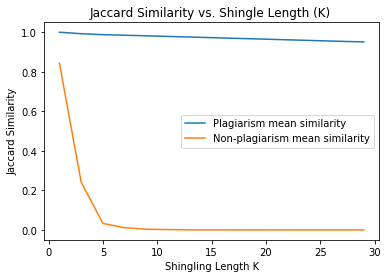

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

fname_train="datasets/plagiarism/articles_1000.train"
fname_truth="datasets/plagiarism/articles_1000.truth"
list_JS_plagiarized_mean=[]
list_JS_non_plagiarized_mean=[]
list_k=[]
for k in range (1,30,2):

    JS_plagiarized_mean, JS_non_plagiarized_mean = JS_of_plagiarized_nonpalgiarized_docs (fname_train, fname_truth,k)
    
    list_JS_plagiarized_mean.append(JS_plagiarized_mean)
    list_JS_non_plagiarized_mean.append(JS_non_plagiarized_mean)
    list_k.append(k)
    
plt.plot(list_k,list_JS_plagiarized_mean)    
plt.plot(list_k,list_JS_non_plagiarized_mean)  
plt.legend(['Plagiarism mean similarity', 'Non-plagiarism mean similarity'])
plt.xlabel('Shingling Length K')
plt.ylabel('Jaccard Similarity')
plt.title('Jaccard Similarity vs. Shingle Length (K) ')
plt.show()                                                                                                
    

The shingle length k paly an impostrant role in the jaccard similarity.
For this type of document a shingle length of k>5 is a resonable threshold 
to detect the plagiarism and non-palgiarism  

## Part II: MinHash
### Part IIA: Prepare shingles for processing
Implement a function that takes the shingled documents and returns a list of item-document pairs sorted by items that we’ll use to compute the minhash signature of each document. Remember that because of the shingling logic we used above, we represent items as 32-bit integers. The function specs are as follows:
- Input is a list of tuples of form (docid, [items])
- Output will be a tuple with two elements:
    - a list of tuples of form (item, docid). It will contain one entry for each item appearing in each document.
    - a list of document ids found in the dataset
- Output should be sorted by item

In [13]:
def invert_shingles(shingled_documents):  

  # initialize list for tuples
    shinglesInDocs = []
  # initialize list for document ids
    docNames = []
    
  # for each document in input
    for i in range(0, len(shingled_documents)):
    # append document id to list
        DocId = shingled_documents[i][0]
        docNames.append(DocId)
    # for each item in document
        for j in range(0, len(shingled_documents[i][1])):
      # append (item, docid) tuple
            shinglesInDocs.append((list(shingled_documents[i][1])[j] , DocId))
  # sort tuple list
    shinglesInDocs.sort(key=lambda tup: tup[0]) # sort by first element
  # return sorted tuple list, and document list
    return shinglesInDocs ,docNames

In [14]:
def shingles_of_documents (filename,k):
    parsed_data = parse_data(filename)
    shingled_documents=[]
    for i in range(len(parsed_data)):
        tmp = shingle_document(parsed_data[i][1], k)
        shingled_item=(parsed_data[i][0],tmp)    
        
        shingled_documents+=[shingled_item]   
    
    return shingled_documents

In [15]:
# Test
#shingled_documents = shingles_of_documents ("datasets/plagiarism/articles_100.train",5)
#invert_shingles(shingled_documents)

### Part IIB: Generate hash functions
Use the generate_random_hash_fn function below to create function make_hashes. Given input num_hashes this function will return a list of hash functions that mimic the random permutation approach used in Minhash calculation. The function specs are:
- Input is an integer num_hash
- Output is a list of hash functions created by function generate_random_hash_fn

In [16]:
import random

def make_random_hash_fn(p=2**33-355, m=4294967295):
    a = random.randint(1,p-1)
    b = random.randint(0, p-1)
    return lambda x: ((a * x + b) % p) % m
#This is an example of how to use this function:
#hash_fn = make_random_hash_fn()
#hash_fn(12345)

In [17]:
def make_hashes (num_hashes):
    hash_fns = []
    for i in range(0,num_hashes):
        hash_fns.append(make_random_hash_fn())
    return hash_fns
# Test
make_hashes(2)

[<function __main__.make_random_hash_fn.<locals>.<lambda>>,
 <function __main__.make_random_hash_fn.<locals>.<lambda>>]

### Part IIC: Construct the Minhash Signature Matrix
Implement a function that builds the Minhash signature matrix. You can use this code as a starting point. It refers to the functions you implemented above and sketches the construction algorithm.

In [24]:
import numpy as np

def make_minhash_signature(shingled_data, num_hashes):
    inv_index, docids = invert_shingles(shingled_data)
    num_docs = len(docids)
  
  # initialize the signature matrix with infinity in every entry
    sigmatrix = np.full([num_hashes, num_docs], np.inf)
  
  # generate hash functions
    hash_funcs = make_hashes(num_hashes)
  
  # iterate over each non-zero entry of the characteristic matrix
    for row, docid in inv_index:
    # update signature matrix if needed 
        for hash_func in range(0,num_hashes):
            sigmatrix[hash_func,docids.index(docid)] = min(sigmatrix[hash_func,docids.index(docid)],hash_funcs[hash_func](row))                     
    # THIS IS WHAT YOU NEED TO IMPLEMENT
  
    return sigmatrix, docids

In [56]:
# Test
#shingled_documents = shingles_of_documents ("datasets/plagiarism/articles_100.train",5)
#make_minhash_signature(shingled_documents, 5)

### Part IID: MinHash similarity estimate
Write a function that computes the similarity of two documents using the minhash matrix computed above. The function specs are:
- Input:
    - id1, id2: document ids
    - minhash_sigmat: minhash signature matrix
    - docids: list of document ids, used to index the columns of the minhash signature matrix
- Output: Jaccard similarity estimated using minhash              

In [31]:
def minhash_similarity(idx1, idx2, minhash_sigmat, docids):
   # get column of the similarity matrix for the two documents
    col_idx1=docids.index(idx1)
    col_idx2=docids.index(idx2)
   
   # calculate the fraction of rows where two columns match
   # hint # np.mean(a == b) computes the fraction of entries in which 
   # two vectors are equal
    minhash_similarity_estimate = np.mean(minhash_sigmat[:, col_idx1] == minhash_sigmat[:, col_idx2])
   
   # return this fraction as the minhash similarity estimate
    return minhash_similarity_estimate 


In [34]:
#print (minhash_similarity('t980','t2023', sigmatrix, docids))
#print (minhash_similarity('t980','t5432', sigmatrix, docids))

### Part IIE: Put these together 
Write a function that given shingled documents computes the Minhash estimated similarities between each pair of documents. This will be similar to your function for Part ID

In [35]:
def minhash_similar_of_documents(shingles,num_hash):
    
    # input "shingles" is shingled_documents
    array_of_minhash_similar_tuples=[]
    shinglesInDocs ,docNames = invert_shingles(shingles)
    sigmatrix, docids = make_minhash_signature(shingles, num_hash)
    
    for i in range(len(shingles)):        
        for j in range (i+1, len(shingles)):                        
            minhash_similar = minhash_similarity(shingles[i][0], shingles[j][0], sigmatrix, docids)                       
            minhash_tuples = (shingles[i][0], shingles[j][0],sigmatrix)
            
            if minhash_similar>=0.8:                
                array_of_minhash_similar_tuples+=[minhash_tuples]
                print(minhash_tuples)
            
    return array_of_minhash_similar_tuples    

In [36]:
#filename= PLAGIARISM_PATH + '/articles_100.train'
#shingles = shingles_of_documents(filename,5)
#minhash_similar_of_documents(shingles,6)

### Part IIF: Experiment 1
Use your function to carry out the following experiment:
What is the effect of the number of hash functions used to compute the Minhash signature on the accuracy of the Minhash estimate of Jaccard similarity. Carry out this experiment on the 1000 document dataset.

In [37]:
def accuracy_of_minhashsig_to_jaccard (fname,num_hash,k):
    
    parsed_data = parse_data (fname)
    docids=[]
    for i in range(len(parsed_data)):
        docids.append(parsed_data[i][0])
        
    shingles= shingles_of_documents(fname,k)
    array_of_minhash_jaccard_accuracy=[]
    
    shinglesInDocs ,docNames = invert_shingles(shingles)
    sigmatrix, docids = make_minhash_signature(shingles, num_hash)
    
    for i in range(len(shingles)):
        for j in range (i+1, len(shingles)):
                        
            minhash_similar = minhash_similarity(shingles[i][0], shingles[j][0], sigmatrix,  docids)
                        
            idx1=docids.index(shingles[i][0])
            idx2=docids.index(shingles[j][0])

            s1=shingle_document(parsed_data[idx1][1], k)
            s2=shingle_document(parsed_data[idx2][1], k)
            jaccard_similar = jaccard(s1,s2)
            
            minhash_jaccard_accuracy = (minhash_similar - jaccard_similar)**2                            
            array_of_minhash_jaccard_accuracy.append(minhash_jaccard_accuracy)
                         
    return array_of_minhash_jaccard_accuracy

In [110]:
filename="datasets/plagiarism/articles_1000.train"
k=5
num_hash=10 
acu_10 = accuracy_of_minhashsig_to_jaccard (filename,num_hash,k)
num_hash=50
acu_50 = accuracy_of_minhashsig_to_jaccard (filename,num_hash,k)
num_hash=100
acu_100 = accuracy_of_minhashsig_to_jaccard (filename,num_hash,k)
num_hash=500
acu_500 = accuracy_of_minhashsig_to_jaccard (filename,num_hash,k)

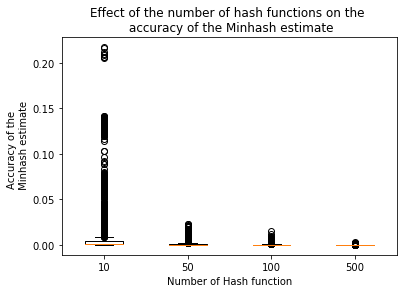

In [129]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.boxplot([acu_10, acu_50, acu_100 ,acu_500]) 
plt.xticks([1,2,3,4], ['10','50','100','500'])
plt.xlabel('Number of Hash function')
plt.ylabel('Accuracy of the  \n Minhash estimate')
plt.title('Effect of the number of hash functions on the \n accuracy of the Minhash estimate')
plt.show() 

This plot shows that for this type of document a number larger than 500 would be sufficient for obtaining a reasonable accuracy. 

## Part III: Locality-Sensitive Hashing
### Implement LSH
Write a function that implements locality sensitive hashing. Function specifications:
- Input:
    - minash_sigmatrix: a minhash signature matrix
    - numhashes: number of hash functions used to construct minhash signature matrix
    - docids: list of document ids
    - threshold a minimum Jaccard similarity threshold
- Output:
    - a list of hash tables 


In [117]:
# save  
acu_10
import  csv

with open("acu_10.csv","w") as f:
    wr = csv.writer(f,delimiter="\n")
    wr.writerow(acu_10)
    
with open("acu_50.csv","w") as f:
    wr = csv.writer(f,delimiter="\n")
    wr.writerow(acu_50)   
    
with open("acu_100.csv","w") as f:
    wr = csv.writer(f,delimiter="\n")
    wr.writerow(acu_100)   

with open("acu_500.csv","w") as f:
    wr = csv.writer(f,delimiter="\n")
    wr.writerow(acu_500)

#### Choosing the number of bands for LSH
Given a similarity threshold, we need to choose the number of bands to use in LSH. Use this function to do this:

In [38]:
import scipy.optimize as opt
import math

def choose_nbands(threshold, nhashes):
    error_fun = lambda x: (threshold-((1/x[0])**(x[0]/nhashes)))**2
    res = opt.minimize(error_fun, x0=(10), method='Nelder-Mead')
    b = int(math.ceil(res['x'][0]))
    r = int(nhashes / b)
    final_t = (1/b)**(1/r) # An approximation to the threshold
    return b, final_t

In [39]:
choose_nbands(0.8,100)

(10, 0.7943282347242815)

#### Hashing a vector
In LSH for each band we hash the r hash values for each document. We can use this function to generate a hash function for vectors

In [40]:
def _make_vector_hash(num_hashes, m=4294967295):
    hash_fns = make_hashes(num_hashes)
    def _f(vec):
        acc = 0
        for i in range(len(vec)):
            h = hash_fns[i]
            acc += h(vec[i])
        #print(acc)
        return acc % m
    return _f

In [44]:
#hash_func=_make_vector_hash(4)
#hash_func((3,4,0,4))

3804127042

In [46]:
# NOTE: This is not my work but I have tried to understand that
from collections import defaultdict

def do_lsh(minhash_sigmatrix, numhashes, docids, threshold):
    b, _ = choose_nbands(threshold, numhashes)
    r = int(numhashes / b)
    narticles = len(docids)
    # hash_func is an array of functions 

    hash_func = _make_vector_hash(r)
    # example: generate hash_func of length 4 then we need to provide a n
    # array of size 4 then it uses that number in the functions and return 
    # a single value 
    #hash_func=_make_vector_hash(4)
    #hash_func((3,4,0,4))
    
    buckets = []
    for band in range(b):
        start_index = int(band * r)
        end_index = min(start_index + r, numhashes)
    
        cur_buckets = defaultdict(list)
    
        for j in range(narticles):
        # THIS IS WHAT YOU NEED TO IMPLEMENT
        
        # The key_val is a single number is obtained by hash_func
        # the input is an array of size [start_index:end_index]. that ts 
        # jth column of the divided signiture matrix 
            key_val=hash_func(minhash_sigmatrix[start_index:end_index,j])
            # for each doc j we have a key_val 
            single_bucket_dict={key_val:(docids[j],)}
            for key in single_bucket_dict:
                if key in cur_buckets:
                    cur_buckets[key]+=(single_bucket_dict[key])
                else:
                    cur_buckets[key]=single_bucket_dict[key]
           
        buckets.append(cur_buckets)
    return buckets

### Find candidate similar article pairs
Write a function that uses the result of your LSH function and returns list of candidate article pairs. Spec:
- Input: the result of do_lsh
- Output: list of tuples (docid1, docid2) each a candidate similar article pair according to LSH

In [48]:
# NOTE: This is not my work but I have tried to understand that
def find_candidate_silimar_documents(buckets):
    candidate_pairs=[]
    for val in range(len(buckets)):
        for key in buckets[val]:
            if len(buckets[val][key])>1:
                for i in range(len(buckets[val][key])-1):
                    candidate=(buckets[val][key][i],buckets[val][key][i+1])
                    candidate_pairs.append(candidate)
        
    return candidate_pairs    

In [49]:
# NOTE: This is not my work but I have tried to understand that
def find_silimar_documents(file_name,k,num_hashes,threshold):
    shingles= shingles_of_documents(file_name,k)
    minhash_sigmat,list_of_documentid=make_minhash_signature(shingles, num_hashes)
    buckets= do_lsh(minhash_sigmat, num_hashes, list_of_documentid, threshold)
    candidate_list=find_candidate_silimar_documents(buckets)
    similar_docs=[]
    for i,j in candidate_list:
        if (i,j) not in similar_docs:
            if minhash_similarity(i, j, minhash_sigmat, list_of_documentid)>0.8:
                similar=(i,j)
                similar_docs.append(similar)
    return similar_docs      

In [50]:
file_name="datasets/plagiarism/articles_100.train"
k=10
num_hashes=30
threshold=0.8
similar_docs= find_silimar_documents(file_name,k,num_hashes,threshold)
similar_docs

[('t980', 't2023'),
 ('t1088', 't5015'),
 ('t1297', 't4638'),
 ('t1768', 't5248'),
 ('t1952', 't3495')]

### Experiment 2: LSH sensitivity
Use these functions to compute the sensitivity and specificity of LSH as a function of the threshold. Use the 10,000 document dataset to perform this experiment.

In [53]:
# NOTE: This is not my work but I have tried to understand that
def LSH_specificity_sensitivity(file_name1,file_name2,k,num_hashes):

    plagiarized_instances,_=list_of_plagiarized_nonpalgiarized_doc(file_name1,file_name2)

    shingles= shingles_of_documents(file_name1,k)
    minhash_sigmat,list_of_documentid=make_minhash_signature(shingles, num_hashes)
    sensitivity=[]
    specificity=[]
    false_positive1=[]

    for threshold in np.arange(0.2,1,0.2):
        buckets= do_lsh(minhash_sigmat, num_hashes, list_of_documentid, threshold)
        candidate_list=find_candidate_silimar_documents(buckets)
        cur_true_positive=len(set(candidate_list).intersection(set(plagiarized_instances)))
        cur_false_positive=len(candidate_list) - cur_true_positive
        cur_false_negative=len(plagiarized_instances)-cur_true_positive
        whole_negative = (len(list_of_documentid))**2 - len(candidate_list)
        whole_positive=len(candidate_list)
        cur_sensitivity= (1.0*cur_true_positive)/whole_positive
        cur_specificity=(1.0*cur_false_positive)/whole_negative
        sensitivity.append(cur_sensitivity)
        specificity.append(cur_specificity)
                                
    return sensitivity, specificity

In [54]:
# NOTE: This is not my work but I have tried to understand that
file_name1="datasets/plagiarism/articles_1000.train"
file_name2="datasets/plagiarism/articles_1000.truth"
k=10
num_hashes=100
sensitivity, specificity= LSH_specificity_sensitivity(file_name1,file_name2,k,num_hashes)

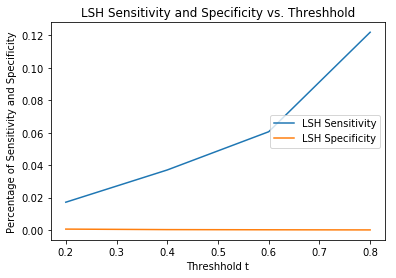

In [55]:
# NOTE: This is not my work but I have tried to understand that
plt.plot(np.arange(0.2,1,0.2),sensitivity)    
plt.plot(np.arange(0.2,1,0.2),specificity)  
plt.legend(['LSH Sensitivity', 'LSH Specificity'],loc=5)
plt.xlabel('Threshhold t')
plt.ylabel('Percentage of Sensitivity and Specificity')
plt.title('LSH Sensitivity and Specificity vs. Threshhold')